In [59]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [ ]:
# import pandas as pd

# # 모든 컬럼에 대해 카테고리별 임신 성공 비율 및 전체 행 대비 비율 비교하는 함수
# def compare_category_distribution(df1, df2, label1, label2):
#     result = {}
#     total_count1 = len(df1)
#     total_count2 = len(df2)

#     for col in df1.columns:
#         if df1[col].dtype == 'object':  # 문자열(카테고리) 타입인 경우만 계산
#             category_counts1 = df1.groupby(col)["임신 성공 여부"].agg(['mean', 'count'])
#             category_counts2 = df2.groupby(col)["임신 성공 여부"].agg(['mean', 'count'])

#             # 비율 계산 (해당 카테고리 개수 / 전체 개수)
#             category_counts1["비율(%)"] = (category_counts1["count"] / total_count1) * 100
#             category_counts2["비율(%)"] = (category_counts2["count"] / total_count2) * 100

#             # 컬럼명 변경
#             category_counts1.columns = [f'{label1} - 임신 성공 비율', f'{label1} - 데이터 개수', f'{label1} - 비율(%)']
#             category_counts2.columns = [f'{label2} - 임신 성공 비율', f'{label2} - 데이터 개수', f'{label2} - 비율(%)']

#             # 두 데이터프레임 병합 (outer join 사용)
#             merged_df = category_counts1.merge(category_counts2, left_index=True, right_index=True, how="outer").fillna(0)
#             result[col] = merged_df

#     return result

# # 두 부류 비교
# comparison_results = compare_category_distribution(no_embryo_no_pregnancy, no_embryo_yes_pregnancy,
#                                                   "이식 0 & 임신 0", "이식 0 & 임신 1")

# # 결과 출력
# for col, df in comparison_results.items():
#     print(f"\n========== 비교 - {col} ==========\n")
#     print(df)
#     print("\n" + "="*50)


NameError: name 'no_embryo_no_pregnancy' is not defined

In [60]:
import os
import logging

def set_affinity(pid, cores):
    os.sched_setaffinity(pid, cores)
set_affinity(0, {21,22,23,24,25,26,27,28,43,44,45,46,47})
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [62]:
train = pd.read_csv('/data/home/brian1501/Minsu/Pregnant/train/data/train.csv').drop(columns=['ID'])
test = pd.read_csv('/data/home/brian1501/Minsu/Pregnant/train/data/test.csv').drop(columns=['ID'])
train.shape, test.shape
train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'
test.loc[test['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'
train = train[~((train["이식된 배아 수"] == 0) & (train["임신 성공 여부"] == 1))]

In [63]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns =['불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '난자 채취 경과일', '난자 해동 경과일']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256321, 61), (90067, 60))

In [64]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

nan_col_list = ['착상 전 유전 진단 사용 여부' ]

for col in nan_col_list:
    train[col] = train[col].fillna(1)
    test[col] = test[col].fillna(1)

In [65]:
drop_col = ["불임 원인 - 정자 농도","DI 출산 횟수","DI 임신 횟수","착상 전 유전 진단 사용 여부","난자 혼합 경과일","부부 주 불임 원인","남성 주 불임 원인","저장된 신선 난자 수","대리모 여부","남성 부 불임 원인","여성 부 불임 원인","부부 부 불임 원인","미세 주입에서 생성된 배아 수","여성 부 불임 원인","불명확 불임 원인","불임 원인 - 자궁내막증" ]

for col in train.columns:
    if col in drop_col:
        train.drop(columns=col, inplace=True)
        test.drop(columns=col, inplace=True)
        
train.shape, test.shape

((256321, 47), (90067, 46))

In [66]:
import numpy as np
import pandas as pd
# 1) -1을 NaN으로 치환
train['배아 이식 경과일'] = train['배아 이식 경과일'].replace(-1, np.nan)
test['배아 이식 경과일'] = test['배아 이식 경과일'].replace(-1, np.nan)
# 2) 숫자 값들을 '0개', '1개' 등으로 매핑 (dict 이용)
mapping_dict = {
    0.0: '0일',
    1.0: '1일',
    2.0: '2일',
    3.0: '3일',
    4.0: '4일',
    5.0: '5일',
    6.0: '6일',
    7.0: '7일'
}

train['배아 이식 경과일'] = train['배아 이식 경과일'].map(mapping_dict)

# 3) NaN 값(Missing)을 'Missing' 범주로 대체
train['배아 이식 경과일'] = train['배아 이식 경과일'].fillna('Missing')

# 4) 최종적으로 카테고리형으로 변환
train['배아 이식 경과일'] = train['배아 이식 경과일'].astype('category')

test['배아 이식 경과일'] = test['배아 이식 경과일'].map(mapping_dict)

# 3) NaN 값(Missing)을 'Missing' 범주로 대체
test['배아 이식 경과일'] = test['배아 이식 경과일'].fillna('Missing')

# 4) 최종적으로 카테고리형으로 변환
test['배아 이식 경과일'] = test['배아 이식 경과일'].astype('category')

print(train)
print(train.dtypes)

       시술 시기 코드 시술 당시 나이  임신 시도 또는 마지막 임신 경과 연수 시술 유형 특정 시술 유형  배란 자극 여부  \
0        TRZKPL  만18-34세                    NaN   IVF     ICSI         1   
1        TRYBLT  만45-50세                    NaN   IVF     ICSI         0   
2        TRVNRY  만18-34세                    NaN   IVF      IVF         1   
3        TRJXFG  만35-37세                    NaN   IVF     ICSI         1   
4        TRVNRY  만18-34세                    NaN   IVF     ICSI         1   
...         ...      ...                    ...   ...      ...       ...   
256346   TRYBLT  만18-34세                    NaN   IVF     ICSI         1   
256347   TRYBLT  만38-39세                    NaN   IVF     ICSI         1   
256348   TRVNRY  만35-37세                    NaN   IVF     ICSI         1   
256349   TRZKPL  만38-39세                    NaN   IVF     ICSI         1   
256350   TRXQMD  만35-37세                    NaN   IVF      IVF         0   

          배란 유도 유형  단일 배아 이식 여부  착상 전 유전 검사 사용 여부  여성 주 불임 원인  ...  난자 기증자 나이  \
0     

In [57]:
set(list(test["배아 이식 경과일"]))

{'0일', '1일', '2일', '3일', '4일', '5일', '6일', '7일', 'Missing'}

In [67]:

if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

if '저장된 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['저장된 배아 수_bin'] = pd.cut(train['저장된 배아 수'], bins=bins, labels=labels)
    test['저장된 배아 수_bin']  = pd.cut(test['저장된 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=30)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=30)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [68]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [69]:

categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부",
    '시술 정자',
    '시술 난자',
        "저장된 신선 난자 수","총_생성_배아_bin","저장된 배아 수_bin"
]
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    # "배아 이식 경과일",
    "배아 해동 경과일"
]+['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수']

for col in categorical_columns:
  if col in train.columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

# numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
#                    "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
#                     '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
#        '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
#        '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# # numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
# #                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
# #                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
# #                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if col in train.columns:
    if train[col].isna().sum():
      if col == "이식된 배아 수":
        train[col].fillna(3, inplace=True)  # -1로 대체
        test[col].fillna(3, inplace = True)
      elif train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
        train[col].fillna(-1, inplace=True)  # -1로 대체
        test[col].fillna(-1, inplace = True)
      else:
        mode_value = train[col].mode()[0]  # 최빈값 구하기
        train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
        test[col].fillna(mode_value, inplace = True)

In [47]:
import pandas as pd

# "이식된 배아 수" 컬럼에 대한 임신 성공 비율 및 데이터 개수 계산
def calculate_pregnancy_success_rate(df, column="이식된 배아 수"):
    # 각 고유값별 임신 성공 여부 평균 (즉, 1의 비율) 및 개수 계산
    result = df.groupby(column)["임신 성공 여부"].agg(['mean', 'count'])
    
    # 컬럼명 변경
    result.columns = ["임신 성공 비율", "데이터 개수"]
    
    return result

# 결과 계산
success_rate_df = calculate_pregnancy_success_rate(train)

# 결과 출력
print("\n========== 컬럼: 이식된 배아 수 ==========\n")
print(success_rate_df)



========== 컬럼: 이식된 배아 수 ==========

          임신 성공 비율  데이터 개수
이식된 배아 수                  
0.0       0.000000   36514
1.0       0.313548   93791
2.0       0.311092  110845
3.0       0.152066   15171


In [70]:
len(categorical_columns) + len(numeric_columns)

78

In [71]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  # #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  # df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  # #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  # #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  # df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [72]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256321, 53), (90067, 53))

In [50]:
y.value_counts()

임신 성공 여부
0    190123
1     66198
Name: count, dtype: int64

In [73]:
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부",
    '시술 정자',
    '시술 난자',
        "저장된 신선 난자 수","총_생성_배아_bin","임신시도_bin","저장된 배아 수_bin","배아 이식 경과일"
]

categorical_columns_new = []
for col in X.columns:
  if col in categorical_columns:
    categorical_columns_new.append(col)


In [91]:
from sklearn.utils.class_weight import compute_class_weight

seed = 4972

def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU",devices='2')
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns_new,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)

    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):
    """
    LightGBM을 Optuna로 하이퍼파라미터 탐색하는 Objective 함수.
    """
    lgbm_params = {
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "metric": trial.suggest_categorical("metric", ["auc"]),
        "random_state": trial.suggest_int('random_state', 42, 42),
        "verbose": trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)
    model_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=categorical_columns_new
    )

    return model_lgbm.best_score_['valid_0']['auc']

In [77]:
import pandas as pd
import numpy as np

for i, col in enumerate(categorical_columns_new):
    # 1) NaN(결측값) 여부 확인
    nan_mask = train[col].isnull()
    if nan_mask.any():
        print(f"[열 인덱스: {i}] {col} 열에 NaN(결측값) 존재")
        print(train.loc[nan_mask, col].head(), "\n")

    # 2) int/str 이외의 타입이 있는지 확인 (float, bool 등)
    invalid_mask = train[col].notnull() & ~train[col].apply(lambda x: isinstance(x, (int, str)))
    if invalid_mask.any():
        print(f"[열 인덱스: {i}] {col} 열에 int/str 이외의 타입 존재")
        print(train.loc[invalid_mask, col].head(), "\n")


In [ ]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
test_pred_cat_total = []
test_pred_lgbm_total = []
# test_pred_xgb_total = []
y_val_total = []
val_pred_cat_total = []
val_pred_lgbm_total = []
cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    y_val_total.append(y_val)
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 50)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)

    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU",devices='2')
    model.load_model("/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx))
    # model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)

    # model_gpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="GPU" )
    # model_gpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_gpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials=50)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params, class_weight=class_weight_dict)
    model_lgbm.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)], 
        categorical_feature=categorical_columns_new)
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    # # roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    # scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    # test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-24 21:27:43,953] A new study created in memory with name: no-name-04e43194-19a6-489f-94d6-3fa896575b8b


Seed 4972 Start!


[I 2025-02-24 21:27:51,121] Trial 0 finished with value: 0.7406501879855459 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7406501879855459.
[I 2025-02-24 21:27:52,377] Trial 1 finished with value: 0.7366485095346593 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7406501879855459.
[I 2025-02-24 21:27:54,433] Trial 2 finished with value: 0.7424128553797584 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial

LGBM val score : 0.7435345040593151


[I 2025-02-24 21:29:39,364] A new study created in memory with name: no-name-b8e6be70-a67c-46a2-8241-4a4882fa29b1


[I 2025-02-24 21:29:46,545] Trial 0 finished with value: 0.7322668047983677 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7322668047983677.
[I 2025-02-24 21:29:47,778] Trial 1 finished with value: 0.7273414846198178 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7322668047983677.
[I 2025-02-24 21:29:49,782] Trial 2 finished with value: 0.7342532677783055 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial

LGBM val score : 0.7366145428903071


[I 2025-02-24 21:31:37,555] A new study created in memory with name: no-name-9b330c40-0f9b-4b91-864e-4619651c9874


[I 2025-02-24 21:31:45,041] Trial 0 finished with value: 0.739600930008314 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.739600930008314.
[I 2025-02-24 21:31:46,331] Trial 1 finished with value: 0.7336518869608438 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.739600930008314.
[I 2025-02-24 21:31:48,455] Trial 2 finished with value: 0.7399177590555621 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 2 

LGBM val score : 0.741337494395081


[I 2025-02-24 21:33:22,811] A new study created in memory with name: no-name-bdd88efd-ad24-42d7-a2ed-52116ae2cc18


[I 2025-02-24 21:33:30,042] Trial 0 finished with value: 0.7383922016497133 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7383922016497133.
[I 2025-02-24 21:33:31,291] Trial 1 finished with value: 0.7328741292667439 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7383922016497133.
[I 2025-02-24 21:33:33,310] Trial 2 finished with value: 0.740052017552279 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 

LGBM val score : 0.7416317202746174


[I 2025-02-24 21:35:07,285] A new study created in memory with name: no-name-29fbb750-e16d-4265-956f-f0a212ad1b6f


[I 2025-02-24 21:35:14,463] Trial 0 finished with value: 0.7417551714833627 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7417551714833627.
[I 2025-02-24 21:35:15,742] Trial 1 finished with value: 0.7371861061832152 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7417551714833627.
[I 2025-02-24 21:35:17,762] Trial 2 finished with value: 0.7426204144877809 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial

LGBM val score : 0.7449255812674838


[I 2025-02-24 21:36:53,499] A new study created in memory with name: no-name-bc0f9f59-87e6-4306-b491-5e29b2d2f430


[I 2025-02-24 21:37:00,723] Trial 0 finished with value: 0.7361611453221149 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7361611453221149.
[I 2025-02-24 21:37:01,990] Trial 1 finished with value: 0.7333370822244243 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7361611453221149.
[I 2025-02-24 21:37:04,022] Trial 2 finished with value: 0.7364708439827795 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial

LGBM val score : 0.7387434307668936


[I 2025-02-24 21:38:50,997] A new study created in memory with name: no-name-0b70461a-c387-40e7-a791-c9b290ed84e8


[I 2025-02-24 21:38:58,214] Trial 0 finished with value: 0.7358952892210548 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7358952892210548.
[I 2025-02-24 21:38:59,524] Trial 1 finished with value: 0.7293529829784718 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7358952892210548.
[I 2025-02-24 21:39:01,583] Trial 2 finished with value: 0.7362018137058293 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial

LGBM val score : 0.7374808794636303


[I 2025-02-24 21:40:47,054] A new study created in memory with name: no-name-bb880d8a-ebc2-4287-a499-785038c9dcbc


[I 2025-02-24 21:40:54,402] Trial 0 finished with value: 0.735463315266618 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.735463315266618.
[I 2025-02-24 21:40:59,762] Trial 1 finished with value: 0.7283850976931091 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.735463315266618.
[I 2025-02-24 21:41:01,903] Trial 2 finished with value: 0.7355488193813671 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 2 

LGBM val score : 0.7371217566199246


[I 2025-02-24 21:42:46,479] A new study created in memory with name: no-name-49e21027-517d-4eb9-b102-34b0e701978b


[I 2025-02-24 21:42:53,863] Trial 0 finished with value: 0.7428189613746891 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7428189613746891.
[I 2025-02-24 21:42:55,144] Trial 1 finished with value: 0.7339603767504448 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7428189613746891.
[I 2025-02-24 21:42:57,217] Trial 2 finished with value: 0.743452545156724 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 

LGBM val score : 0.7450152765656672


[I 2025-02-24 21:44:30,447] A new study created in memory with name: no-name-cbd33128-f4a6-429b-ab04-490e14523dc9


[I 2025-02-24 21:44:37,731] Trial 0 finished with value: 0.7340199074459571 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.028176029297306456, 'n_estimators': 1730, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7340199074459571.
[I 2025-02-24 21:44:39,007] Trial 1 finished with value: 0.72886976932362 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005944336111080004, 'n_estimators': 113, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7340199074459571.
[I 2025-02-24 21:44:41,072] Trial 2 finished with value: 0.7346008094426608 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.07957145920376708, 'n_estimators': 397, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 2

LGBM val score : 0.7364557438043582


In [ ]:
np.mean(scores_total), scores_total

(0.741201564719638,
 [0.7414238034278366,
  0.736325829012412,
  0.7433595364013841,
  0.7422114481666402,
  0.7451912528111095,
  0.7392552305863451,
  0.739200440298218,
  0.7389758112353779,
  0.7423986158888373,
  0.7436736793682186])

In [ ]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [ ]:
test_pred_total_mean

array([0.00424094, 0.0035059 , 0.32189225, ..., 0.68036313, 0.3850272 ,
       0.00482632])

In [ ]:

sample_submission = pd.read_csv('/data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('data/Add_feature_reason2_lgbmcat2_Minsu_seed.csv', index=False)

In [ ]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


In [95]:
import json
with open("lgbm_params_minsu.json", "w") as f:
    json.dump(lgbm_param_list, f)

with open("/data/home/brian1501/Minsu/Pregnant/train/lgbm_params_minsu.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [97]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)

    model_gpu = CatBoostClassifier()
    model_gpu.load_model("/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns_new)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_gpu = model_gpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat gpu val score : {}'.format(roc_auc_score(y_val,val_pred_gpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_gpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_gpu = model_gpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_gpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_gpu))

Seed 4972 Start!
Cat gpu val score : 0.7451971683232159
LGBM val score : 0.7435345040593151
Ensemble val score : 0.7450429488298911
Cat gpu val score : 0.7427893639808648
LGBM val score : 0.741337494395081
Ensemble val score : 0.7426223437725956
Cat gpu val score : 0.7424724478354583
LGBM val score : 0.7416317202746174
Ensemble val score : 0.7426420735703257
Cat gpu val score : 0.7449202260871335
LGBM val score : 0.7449255812674838
Ensemble val score : 0.7453531455407716
Cat gpu val score : 0.740316328278594
LGBM val score : 0.7387434307668936
Ensemble val score : 0.7402497540113002
Cat gpu val score : 0.7385353494342578
LGBM val score : 0.7374808794636303
Ensemble val score : 0.738596655920287
Cat gpu val score : 0.7383553986892044
LGBM val score : 0.7371217566199246
Ensemble val score : 0.7383284797707665
Cat gpu val score : 0.7440963149049448
LGBM val score : 0.7450152765656672
Ensemble val score : 0.7448823346107372
Cat gpu val score : 0.7376609851434267
LGBM val score : 0.73645574

(0.741201564719638,
 [0.7414238034278366,
  0.736325829012412,
  0.7433595364013841,
  0.7422114481666402,
  0.7451912528111095,
  0.7392552305863451,
  0.739200440298218,
  0.7389758112353779,
  0.7423986158888373,
  0.7436736793682186])

In [98]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13512.,  2390.,  3343.,  6064.,  9251., 13213., 16854., 15220.,
         9625.,   595.]),
 array([1.02789631e-04, 8.84367804e-02, 1.76770771e-01, 2.65104762e-01,
        3.53438753e-01, 4.41772743e-01, 5.30106734e-01, 6.18440725e-01,
        7.06774715e-01, 7.95108706e-01, 8.83442697e-01]),
 <BarContainer object of 10 artists>)

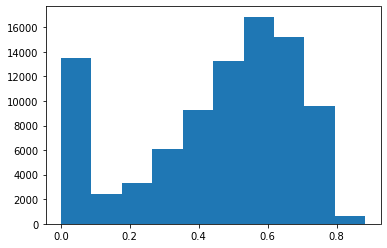

In [99]:
plt.hist(test_pred_total_mean)

In [101]:

sample_submission = pd.read_csv('/data/home/brian1501/Minsu/Pregnant/data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('/data/home/brian1501/Minsu/Pregnant/data/Add_feature_Minsu_seed.csv', index=False)